# Beam Pruning with pywrapfst

A common problem in Large Vocabulary Continuous Speech Recognition (LVCSR) is the large number of hypotheses to explore when decoding. Indeed, searching for the best sequence of words with a vocabulary of several hundred thousand words is far beyond the capacity of any modern computers. The state-of-the-art solution for this problem is to explore only a subset of all the hypotheses. The subset of hypotheses is chosen to be all the hypotheses whose (log-)likelihood  is not less than the (log-)likelihood of the best sequence minus a certain threshold (i.e. beam) at a given time. More formally, the subset of hypotheses selected $\hat{\mathcal{H}}_t(\alpha)$ at a given time $t$ for a given beam $\alpha$ is defined as:

$$
\hat{\mathcal{H}}_t(\alpha) = \big\{ h_t : h_t \in \mathcal{H}_t, \mathcal{L}(h_t) \ge \mathcal{L}(h^*_t) - \alpha \big\}
$$

where $\mathcal{H}_t$ is the set of all hypotheses at time $t$, $\mathcal{L}(h_t)$ is the (log-)likelihood of the hypothesis $h_t$ and $h^*_t$ is the hypothesis with the highest (log-)likelihood:

$$
h^*_t \in \mathcal{H} \; \text{and} \; \forall \, h_t \in \mathcal{H}_t, \mathcal{L}(h^*_t) \ge \mathcal{L}(h_t)
$$

The operation to keep only the hypotheses falling into a specific beam is usually denoted by **beam pruning**. This notebook shows how to implement the beam pruning algorithm.

First, we load the modules we'll need for this.

In [1]:
import copy
import numpy as np
import pywrapfst as fst

# Preparing data

We'll work with a precomputed and very simple trellis.

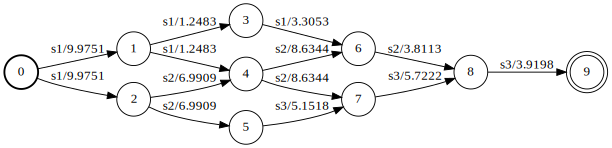

In [2]:
T = fst.Fst.read('trellis.fst')
T

In this example, we see that the sequence of state ```s1, s1, s1, s2, s3``` is the most likely sequence of label whereas the sequence ```s1, s2, s2, s3, s3``` is the most unlikely. Our pruning algorithm should ideally keep the first sequence and remove the second one and eventually other unlikely sequences.

# Beam Pruning

The Beam Pruning algorithm needs to run time-synchronously as comparing the likelihood of sequences at difference time step would result in keeping only the shortest sequence. The main idea is to copy only the likely path from the original trellis. We split the algorithm into several sub-functions. This is not very efficient but greatly simplifies the readibility. Also, our implementation handles the case when they are epsilon links in the trellis though there are none in our example.

We define the hypothesis/epsilon_link objects. The main purpose of these two classes is to create a container (orig_state arc, score) which is hashable, i.e. they can be used as key in a dictionary. 

In [3]:
class EpsilonLink:
    
    def __init__(self, state, arc):
        self.state = state
        self.arc = arc
    
    def __hash__(self):
        return hash((self.state, self.arc.ilabel, self.arc.olabel, self.arc.nextstate))
    
    def __eq__(self, other):
        return (self.state == other.state and
        self.arc.ilabel == other.arc.ilabel and
        self.arc.olabel == other.arc.olabel and
        self.arc.nextstate == other.arc.nextstate)
    
    # Just for debugging.
    def __repr__(self):
        return str(self.state) + '(' + str(self.arc.ilabel) + ':' + \
            str(self.arc.olabel) + ')' + ' -> ' + str(self.arc.nextstate) 

class Hypothesis: 
    
    def __init__(self, state, arc, weight):
        self.state = state
        self.arc = arc
        self.score = fst.times(weight, arc.weight)
    
    def __hash__(self):
        return hash((self.state, self.arc.ilabel, self.arc.olabel, self.arc.nextstate))
    
    def __eq__(self, other):
        return (self.state == other.state and
        self.arc.ilabel == other.arc.ilabel and
        self.arc.olabel == other.arc.olabel and
        self.arc.nextstate == other.arc.nextstate)
        
    # Just for debugging.
    def __repr__(self):
        return str(self.state) + '(' + str(self.arc.ilabel) + ':' + \
            str(self.arc.olabel) + ')' + ' -> ' + str(self.arc.nextstate) + \
            ': ' + str(float(self.score))

This function implements browsing the FST for exactly one timestep. A time step means that we consume exactly one input symbols per hypothesis. There can be any number of epsilon input symbols per timestep. 

In [4]:
def get_hypotheses(trellis, queue):
    '''Browse the trellis to get the hypotheses for the
    next time step.
    
    Args:
        trellis (fst.Fst): The trellis to browse.
        queue (list): The list of states from which to 
            start to brow the trellis. Each element of 
            the list is a tuple (state, weight) indicating
            the state from which to start and the weight
            of the current hypothesis for the associated 
            state. 
    
    Returns:
        list: The list of hypotheses. An hypothesis is a tuple
            (src_state, ilabel, olabel, weight dest_state).
        set: The set of epsilon arcs that was encouter while
            browsing.
            
    '''
    copy_queue = copy.copy(queue)
    epsilons = set()
    hypotheses = list()
    while len(copy_queue) > 0:
        state, weight = copy_queue.pop()
        for arc in trellis.arcs(state):
            if arc.ilabel == 0:
                # Epsilon link ! We need to consume one input label
                # per timestep so we add the next state to explore.
                epsilons.add(EpsilonLink(state, arc))
                copy_queue.append(arc.nextstate, fst.times(weight, arc.weight))
            else:
                hypotheses.append(Hypothesis(state, arc, weight))
                
    return epsilons, hypotheses

This function does the the actual beam pruning by selecting only the hypotheses that are within the beam.

In [5]:
def select_hypotheses(hypotheses, beam):
    '''Select the hypotheses that are within the beam.
    
    Args:
        hypotheses (list): List of hypotheses to filter.
        beam (float): Beam threshold.
        
    Returns:
        list: The selected hypotheses.
        
    '''
    # Sort the hypotheses
    sorted_hypotheses = sorted(hypotheses, key=lambda hyp: float(hyp.score))
    threshold = float(sorted_hypotheses[0].score) + beam
    return list(filter(lambda hyp: float(hyp.score) < threshold, hypotheses))

Finally, this function handles the copying of the selected hypotheses from the dense trellis to the pruned one.

In [6]:
def copy_hypotheses(state_mapping, hypotheses, copy_fst):
    '''Copy into the new FST the set of hypotheses.
    
    Args:
        state_mapping (dict): Mapping of the state index between the original
            and copied FST.
        hypotheses (set): The hypotheses to copy.
        copy_fst (fst.MutableFst): The FST where to copy the hypotheses.
        
    '''
    for hypothesis in hypotheses:
        # Source state.
        if hypothesis.state in state_mapping:
            copy_src = state_mapping[hypothesis.state]
        else:
            copy_src = state_mapping[hypothesis.state] = copy_fst.add_state()

        # Destination state.
        if hypothesis.arc.nextstate in state_mapping:
            copy_dest = state_mapping[hypothesis.arc.nextstate]
        else:
            copy_dest = state_mapping[hypothesis.arc.nextstate] = copy_fst.add_state()

        copy_arc = hypothesis.arc.copy()
        copy_arc.nextstate = copy_dest
        copy_fst.add_arc(copy_src, copy_arc)            

Putting everything together, the main algorithm just has to manage the ending condition. Also, note that we call the ```connect``` method at the very end. This is to remove the paths that are invalid (i.e. cannot reach the final state) that may have been created while pruning.

In [7]:
def beam_pruning(trellis, beam):
    '''Beam Pruning algorithm.
    
    Args:
        trellis (fst.Fst): trellis to prune.
        beam (float): beam pruning threshold.
    
    Returns:
        fst.Fst: The pruned trellis
        
    '''
    pruned_trellis = fst.Fst(trellis.arc_type())
    pruned_trellis.set_input_symbols(trellis.input_symbols())
    pruned_trellis.set_output_symbols(trellis.output_symbols())
        
    # List of states corresponding to the current timestep.
    queue = [(trellis.start(), fst.Weight.One(pruned_trellis.arc_type()))]
    
    # Create the initial state. 
    init_state = pruned_trellis.add_state()
    pruned_trellis.set_start(init_state)
    state_mapping = {}
    state_mapping[trellis.start()] = init_state
        
    finished = False
    while not finished:
        # Get all hypotheses for the current timestep.
        eps, hypotheses = get_hypotheses(trellis, queue)
        
        if len(hypotheses) == 0:
            for state, _ in queue:
                pruned_trellis.set_final(state_mapping[state])
            finished = True
            continue
        
        # Select the valid hypotheses according to the beam.
        hypotheses = select_hypotheses(hypotheses, beam)
        
        # From the chosen hypotheses, the list of states to explore at 
        # the next iteration.
        queue = [(hypothesis.arc.nextstate, hypothesis.score) for hypothesis in hypotheses]
        
        # Create the list of arcs/state to copy and remove duplicates.
        to_copy = eps.union(set(hypotheses))
        
        # Make the copy.
        copy_hypotheses(state_mapping, to_copy, pruned_trellis)
        
    # Return the pruned trellis where invalid paths have been removed.
    return pruned_trellis.connect()

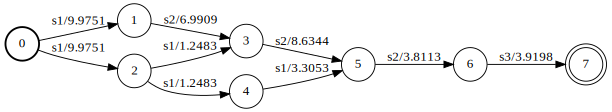

In [8]:
beam_pruning(T, 7)

For convenience we show again the original trellis below:

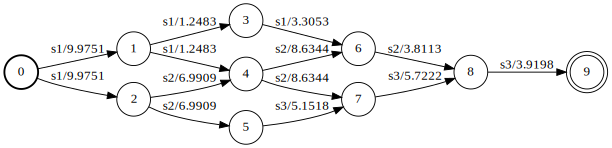

In [9]:
T 

That's it !